# Blower door building air leakage test

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2FA06Blow_door.ipynb)

[Building airtightness](https://en.wikipedia.org/wiki/Building_airtightness) is descibed by power law relation between pressure difference and air flow rate,

$$\dot{V} = K \cdot (\Delta p)^n$$

where:

- $\dot{V}$ is the volumetric leakage airflow rate, m³ h⁻¹;
- $\Delta p$ - pressure difference across the building envelope, Pa;
- $n$ - airflow exponent (0.5 ≤ $n$ ≤ 1);
- $K$ - air leakage coefficient, $\mathrm{m^3 h^{−1} Pa^{−n}}$.

The airflow exponent $n$ and the air leakage coefficient $K$ can be measured experimentally from data data obtained in a [blower door air leakage test](https://en.m.wikipedia.org/wiki/Blower_door).


This notebook demonstrates how to determine the coefficients $K$ and $n$ from the power law of flow through an orifice
$$\dot{V} = K \cdot (\Delta p)^n$$ 
using linear regression on log-transformed of experimental data obtained in a [blower door air leakage test](https://en.m.wikipedia.org/wiki/Blower_door). We also calculate the uncertainties in $K$ and $n$.

## Measured data

The measured data consists of pressure differences, $\Delta p$, and corresponding volumetric flow rates, $\dot{V}$.

| Test | $\Delta p$ / (Pa) | $\dot{V}$ / (m³/h) |
|------|--------:|---------:|
| 0    | 0       | 0        |
| 1    | 10      | 237      |
| 2    | 20      | 364      |
| 3    | 30      | 444      |
| 4    | 40      | 625      |
| 5    | 50      | 688      |
| 6    | 60      | 704      |

## Estimation of coefficients
### Step 1: Linearize the equation

The equation $\dot{V} = K \cdot (\Delta p)^n$ is linearized by taking $\log_{10}$ of both sides:

$$
\log_{10}(\dot{V}) = \log_{10}(K) + n \cdot \log_{10}(\Delta p)
$$

This is of the form $y = a x + b$, where:
- $y = \log_{10}(\dot{V})$
- $x = \log_{10}(\Delta p)$
- $b = \log_{10}(K)$
- $a = n$

---

### Step 2: Perform linear regression

We use `scipy.stats.linregress` to perform linear regression on the log-transformed data. The regression provides:
- Slope $a$: represents $n$.
- Intercept $b$: represents $\log_{10}(K)$.
- Standard error of the slope $\sigma_a$: uncertainty in $n$.
- Standard error of the intercept $\sigma_b$: uncertainty in $\log_{10}(K)$.

---

### Step 3: Extract parameters

From the regression results:
- $n = a$
- $K = 10^b$

---

### Step 4: Calculate uncertainties

#### Uncertainty in $n$
The uncertainty in $n$ is the standard error of the slope:

$$
\sigma_n = \sigma_a
$$

#### Uncertainty in $K$
The uncertainty in $K$:

$$
\sigma_K = K \cdot \ln(10) \cdot \sigma_b
$$

is calculated using simlified formula for [propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) for a function of a single variable. If $K = f(b)$, then the uncertainty $\sigma_K$ is given by:

$$
\sigma_K = \left| \frac{df}{db} \right| \cdot \sigma_b
$$

where:
- $b$ is the intercept from the linear regression,
- $\sigma_b$ is its standard error (uncertainty) of intercept $b$.

The relationship between $K$ and the intercept $a$ is given by:

$$
K = 10^b
$$

##### Step 1: Compute the derivative of $K$ with respect to $b$

The function $K = 10^b$ can be rewritten using the natural logarithm:

$$
K = e^{b \cdot \ln(10)}
$$

The derivative of $K$ with respect to $b$ is:

$$
\frac{dK}{db} = \ln(10) \cdot e^{b \cdot \ln(10)} = \ln(10) \cdot 10^b = \ln(10) \cdot K
$$

##### Step 2: Apply the error propagation formula

Substitute the derivative into the error propagation formula:

$$
\sigma_K = \left| \frac{dK}{db} \right| \cdot \sigma_b = \left| \ln(10) \cdot K \right| \cdot \sigma_b
$$

Since $K$ and $\ln(10)$ are positive, the absolute value can be dropped:

$$
\sigma_K = K \cdot \ln(10) \cdot \sigma_b
$$

where:

- $K$: value calculated from $K = 10^b$.
- $\ln(10)$: constant factor arising from the derivative of $10^b$.
- $\sigma_b$: standard error of the intercept $b$, which quantifies the uncertainty in $b$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Given data
delta_p = np.array([0, 10, 20, 30, 40, 50, 60])        # Pa
V_dot = np.array([0, 237, 364, 444, 625, 688, 704])    # m³/h

# Linearize the equation using log10 (exclude the (0, 0) point)
log_delta_p = np.log10(delta_p[1:])
log_V_dot = np.log10(V_dot[1:])

# Perform linear regression
result = stats.linregress(log_delta_p, log_V_dot)

a = result.slope
b = result.intercept
sigma_a = result.stderr
sigma_b = result.intercept_stderr

r_square = result.rvalue**2

# Extract parameters
n = a
K = 10**b
sigma_n = sigma_a
sigma_K = K * np.log(10) * sigma_a

# Output results
print(f"n = {n:.4f} ± {sigma_n:.4f}")
print(f"K = {K:.4f} ± {sigma_K:.4f}")
print(f"R² = {r_square:.4f}")

n = 0.6434 ± 0.0442
K = 53.3956 ± 5.4338
R² = 0.9815


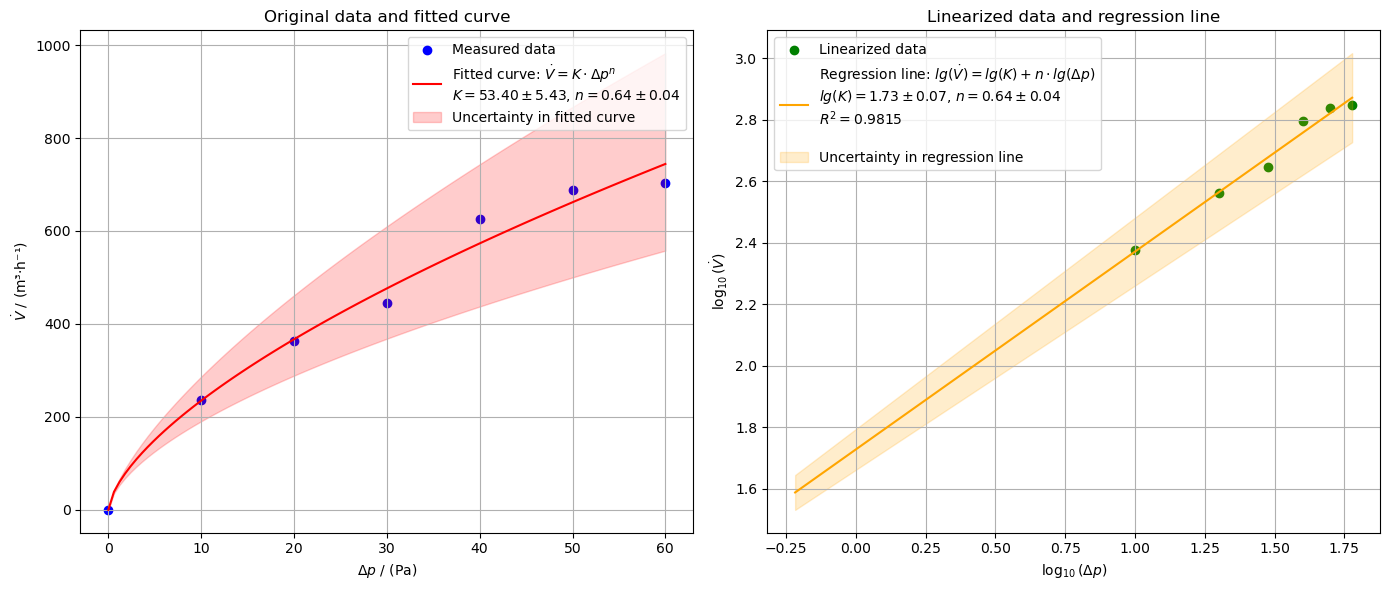

In [2]:
# Plot
# =====
# Create a range of delta_p values for plotting the fitted curve
# Range of delta_p values, including 0
delta_p_range = np.linspace(0, 60, 100)
# Corresponding log10 values, excluding 0
log_delta_p_range = np.log10(delta_p_range[1:])

# Calculate the fitted curve and regression line
# Fitted curve: V_dot = K * delta_p^n
V_dot_fitted = K * delta_p_range**n

# Regression line: log10(V_dot) = log10(K) + n * log10(delta_p)
log_V_dot_fitted = b + a * log_delta_p_range

# Uncertainty bounds in the fitted curve
V_dot_upper = (K + sigma_K) * delta_p_range**(n + sigma_n)
V_dot_lower = (K - sigma_K) * delta_p_range**(n - sigma_n)

# Uncertainty bounds n the regression line
log_V_dot_upper = (b + sigma_b) + (a + sigma_a) * log_delta_p_range
log_V_dot_lower = (b - sigma_b) + (a - sigma_a) * log_delta_p_range

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First pane: Original data and fitted curve with uncertainty
ax1.scatter(delta_p, V_dot,
            color='blue',
            label='Measured data')
ax1.plot(delta_p_range, V_dot_fitted,
         color='red',
         label=f'Fitted curve: $\dot{{V}} = K \cdot \Delta p^n$\n'
         f'$K = {K:.2f} \pm {sigma_K:.2f}$, $n = {n:.2f} \pm {sigma_n:.2f}$')
ax1.fill_between(delta_p_range, V_dot_lower, V_dot_upper,
                 color='red', alpha=0.2,
                 label='Uncertainty in fitted curve')
ax1.set_xlabel('$\Delta p$ / (Pa)')
ax1.set_ylabel('$\dot{V}$ / (m³·h⁻¹)')
ax1.set_title('Original data and fitted curve')
ax1.legend()
ax1.grid(True)

# Second pane: Linearized data and regression line with uncertainty
ax2.scatter(log_delta_p, log_V_dot,
            color='green',
            label='Linearized data')
ax2.plot(log_delta_p_range, log_V_dot_fitted, 
         color='orange',
         label=f'Regression line: '
         f'$lg(\dot{{V}}) = lg(K) + n \cdot lg(\Delta p)$\n'
         f'$lg(K) = {b:.2f} \pm {sigma_b:.2f}$, $n = {a:.2f} \pm {sigma_a:.2f}$'
         f'\n$R^2 = {r_square:.4f}$\n')
ax2.fill_between(log_delta_p_range, log_V_dot_lower, log_V_dot_upper, 
                 color='orange', alpha=0.2,
                 label='Uncertainty in regression line')
ax2.set_xlabel('$\log_{10}(\Delta p)$')
ax2.set_ylabel('$\log_{10}(\dot{V})$')
ax2.set_title('Linearized data and regression line')
ax2.legend()
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
